Deliverable: Create a jupyter notebook that processes the data and comes up with rough clustering of survey responses based on the customer demographics. Output any visualizations that can help describe the clustering. Output a csv file with clustering assignments for survey responses (survey responses should be labeled via column A). Bonus points for any visualizations of interesting patterns in the data.

Tips: k-NN, k-means, DBSCAN, hierarchical clustering, HAC, decision trees

In [ ]:
import re
import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

In [ ]:
# initialize the data -----------
df = pd.read_excel("init_data.xlsx",header=1, sheet_name="Q3 Customer Typing Survey", usecols="A, BJ:BN")
df.rename(columns={
    "FF_CUSTOMER_ID": "customer_id",
    "Which of the following best reflect your gender?": "gender",
    "What is your age?": "age",
    "What is your marital status?": "marital_status",
    "What does your employment look like currently?": "employment_status",
    "What is your household income?": "household_income"
}, inplace=True)

In [ ]:
# dealing with ranges (age and income columns) ------

def age_to_mid(age_str: str) -> float:
    if not isinstance(age_str, str) or age_str.strip() == "" or age_str == "Prefer_Not_Say":
        return np.nan
    m = re.match(r"^\s*(\d+)\s*-\s*(\d+)\s*$", age_str)
    if m:
        lo, hi = map(int, m.groups())
        return (lo + hi) / 2.0
    m2 = re.match(r"^\s*(\d+)\s*\+\s*$", age_str)  # e.g., "65+"
    if m2:
        lo = int(m2.group(1))
        return lo + 5 # assuming midpoint for a range of 10 years
    return np.nan


df["age_num"] = df["age"].apply(age_to_mid)

def income_to_mid(income_str: str) -> float:
    if not isinstance(income_str, str) or income_str.strip() == "" or income_str == "Prefer_Not_Say":
        return np.nan
    if re.match(r"^\s*<\s*\$?\s*75[,0-9]*\s*$", income_str):
        return 75_000 / 2.0
    m = re.match(r"^\s*\$?\s*([\d,]+)\s*-\s*\$?\s*([\d,]+)\s*$", income_str)
    if m:
        lo = int(m.group(1).replace(",", ""))
        hi = int(m.group(2).replace(",", ""))
        return (lo + hi) / 2.0
    if re.match(r"^\s*\$?\s*250[,0-9]*\s*\+\s*$", income_str):
        return 300_000.0  # assuming 250–350k midpoint
    return np.nan

df["household_income_num"] = df["household_income"].apply(income_to_mid)

In [ ]:
num_cols = ["age_num", "household_income_num"]
cat_cols = ["gender", "marital_status", "employment_status"]

# one-hot encode categoricals (keep "Prefer_Not_Say" as its own level)
ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
ct = ColumnTransformer(
    transformers=[
        ("cat", ohe, cat_cols),
        ("pass_num", "passthrough", num_cols),
    ],
    remainder="drop",
)

X = ct.fit_transform(df[cat_cols + num_cols])

# get feature names
ohe_names = ct.named_transformers_["cat"].get_feature_names_out(cat_cols)
feature_names = list(ohe_names) + num_cols

# making another df for easy viewing/debugging
X_df = pd.DataFrame(X, columns=feature_names, index=df.index)

# looking at features yayyy
print("Encoded feature matrix shape:", X.shape)
print("First 10 feature names:", feature_names[:20])

Encoded feature matrix shape: (4748, 21)
First 10 feature names: ['gender_Female', 'gender_Male', 'gender_Non-binary', 'gender_Not listed / prefer not to say', 'gender_nan', 'marital_status_In a relationship, but not living together', 'marital_status_Married / partnered / living together', 'marital_status_Prefer not to say', 'marital_status_Single', 'marital_status_nan', 'employment_status_Currently unemployed', 'employment_status_Employed, 100% on-location / away from home', 'employment_status_Employed, 100% remote / from home', 'employment_status_Employed, Hybrid work on-location & remote', 'employment_status_Other (please specify)', 'employment_status_Prefer not to say', 'employment_status_Retired', 'employment_status_Student', 'employment_status_nan', 'age_num']


In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler(with_mean=True)
X_scaled = scaler.fit_transform(X)


Feature matrix shape: (4612, 18)
Example features: ['gender_Female', 'gender_Male', 'gender_Non-binary', 'gender_Not listed / prefer not to say', 'marital_status_In a relationship, but not living together', 'marital_status_Married / partnered / living together', 'marital_status_Prefer not to say', 'marital_status_Single']


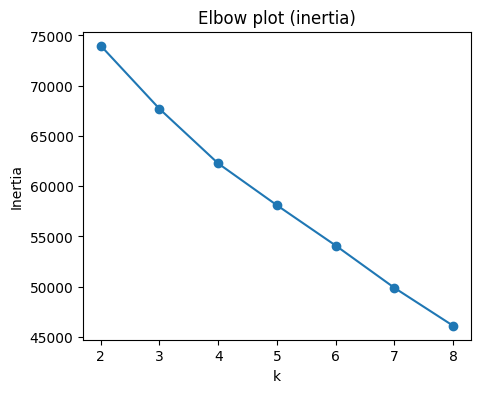

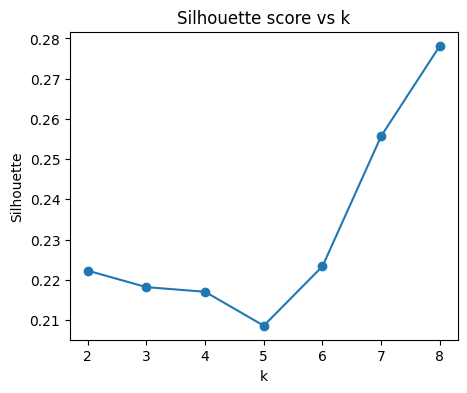

Selected k (max silhouette): 8  | silhouette=0.278
Cluster sizes:
 cluster_kmeans
0     342
1     835
2     756
3    1466
4     720
5     136
6     192
7     165
Name: count, dtype: int64
Saved: cluster_assignments_kmeans.csv


In [ ]:
# --- K-MEANS CLUSTERING: ENCODE -> SCALE -> SWEEP K -> FIT FINAL ---

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import sklearn
from packaging import version

# 0) Basic sanity: keep only rows with a customer_id
df = df.dropna(subset=["customer_id"]).reset_index(drop=True)

# 1) Columns to use (categorical one-hot + numeric passthrough)
cat_cols = ["gender", "marital_status", "employment_status"]
num_cols = ["age_num", "household_income_num"]

# Optional: if any numeric still missing, impute with median (safe for clustering)
from sklearn.impute import SimpleImputer
num_imp = SimpleImputer(strategy="median")
df[num_cols] = num_imp.fit_transform(df[num_cols])

# 2) OHE (handle sklearn version differences for dense output)
if version.parse(sklearn.__version__) >= version.parse("1.2"):
    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
else:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)

ct = ColumnTransformer(
    transformers=[
        ("cat", ohe, cat_cols),
        ("num", "passthrough", num_cols),
    ],
    remainder="drop",
)

X_enc = ct.fit_transform(df[cat_cols + num_cols])

# Recover feature names (robust across versions)
try:
    ohe_names = ct.named_transformers_["cat"].get_feature_names_out(cat_cols)
except AttributeError:
    cats = ct.named_transformers_["cat"].categories_
    ohe_names = []
    for col, cats_for_col in zip(cat_cols, cats):
        ohe_names += [f"{col}__{c}" for c in cats_for_col]
feature_names = list(ohe_names) + num_cols

# 3) Scale (dense matrix here, so centering is fine)
scaler = StandardScaler(with_mean=True)
X = scaler.fit_transform(X_enc)

print("Feature matrix shape:", X.shape)
print("Example features:", feature_names[:8])

# 4) Sweep k and compute inertia (elbow) + silhouette (quality)
k_range = range(2, 9)
inertias = []
silhouettes = []

for k in k_range:
    km = KMeans(n_clusters=k, n_init="auto", random_state=42)
    labels = km.fit_predict(X)
    inertias.append(km.inertia_)
    sil = silhouette_score(X, labels)
    silhouettes.append(sil)

# Plot elbow and silhouette
plt.figure(figsize=(5,4))
plt.plot(list(k_range), inertias, marker="o")
plt.title("Elbow plot (inertia)")
plt.xlabel("k"); plt.ylabel("Inertia")
plt.show()

plt.figure(figsize=(5,4))
plt.plot(list(k_range), silhouettes, marker="o")
plt.title("Silhouette score vs k")
plt.xlabel("k"); plt.ylabel("Silhouette")
plt.show()

# 5) Pick best k by max silhouette (simple, effective)
best_k = int(k_range[np.argmax(silhouettes)])
print(f"Selected k (max silhouette): {best_k}  | silhouette={max(silhouettes):.3f}")

# 6) Fit final model and attach labels
kmeans = KMeans(n_clusters=best_k, n_init="auto", random_state=42)
df["cluster_kmeans"] = kmeans.fit_predict(X)

# Quick cluster sizes
print("Cluster sizes:\n", df["cluster_kmeans"].value_counts().sort_index())

# 7) Export assignments
df[["customer_id", "cluster_kmeans"]].to_csv("cluster_assignments_kmeans.csv", index=False)
print("Saved: cluster_assignments_kmeans.csv")


In [ ]:
import numpy as np
import pandas as pd
import sklearn
from packaging import version
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

# Keep only rows with an id
df = df.dropna(subset=["customer_id"]).reset_index(drop=True)

# Columns
cat_cols = ["gender", "marital_status", "employment_status"]
num_cols = ["age_num", "household_income_num"]

# Impute numeric (just in case)
num_imp = SimpleImputer(strategy="median")
df[num_cols] = num_imp.fit_transform(df[num_cols])

# One-hot encoder (handle sklearn version differences)
if version.parse(sklearn.__version__) >= version.parse("1.2"):
    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
else:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)

ct = ColumnTransformer(
    transformers=[
        ("cat", ohe, cat_cols),
        ("num", "passthrough", num_cols),
    ],
    remainder="drop",
)

X_enc = ct.fit_transform(df[cat_cols + num_cols])

# Feature names (robust)
try:
    ohe_names = ct.named_transformers_["cat"].get_feature_names_out(cat_cols)
except AttributeError:
    cats = ct.named_transformers_["cat"].categories_
    ohe_names = []
    for col, cats_for_col in zip(cat_cols, cats):
        ohe_names += [f"{col}__{c}" for c in cats_for_col]
feature_names = list(ohe_names) + num_cols

# Scale (dense matrix → centering is fine)
scaler = StandardScaler(with_mean=True)
X = scaler.fit_transform(X_enc)

print("Encoded & scaled shape:", X.shape)


Encoded & scaled shape: (4612, 18)


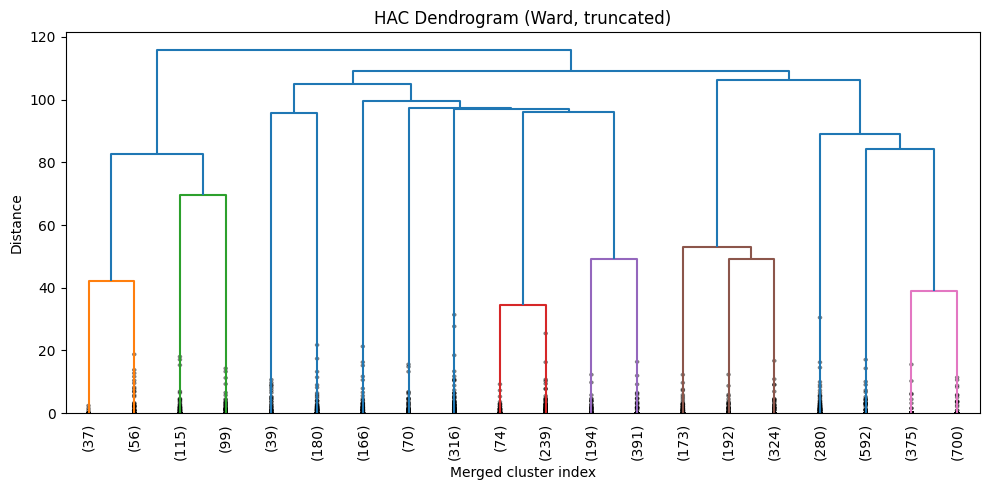

In [ ]:
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram

# Ward linkage on scaled features (Euclidean)
Z = linkage(X, method="ward")

plt.figure(figsize=(10, 5))
dendrogram(
    Z,
    truncate_mode="lastp",  # show last merges as 'p' leaf clusters
    p=20,                   # show up to 20 leaf clusters (tweak if needed)
    leaf_rotation=90.,
    leaf_font_size=10.,
    show_contracted=True
)
plt.title("HAC Dendrogram (Ward, truncated)")
plt.xlabel("Merged cluster index")
plt.ylabel("Distance")
plt.tight_layout()
plt.show()


In [ ]:
# -- Ensure HAC labels exist (creates k=7 and k=8 if missing) --
import numpy as np
import pandas as pd
import sklearn
from packaging import version
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.cluster import AgglomerativeClustering

assert "customer_id" in df.columns, "Expected an 'customer_id' column."

cat_cols = ["gender", "marital_status", "employment_status"]
num_cols = ["age_num", "household_income_num"]

# Impute numerics if needed
num_imp = SimpleImputer(strategy="median")
df[num_cols] = num_imp.fit_transform(df[num_cols])

# OHE (version-safe dense output)
if version.parse(sklearn.__version__) >= version.parse("1.2"):
    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
else:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)

ct = ColumnTransformer(
    transformers=[
        ("cat", ohe, cat_cols),
        ("num", "passthrough", num_cols),
    ],
    remainder="drop",
)

X_enc = ct.fit_transform(df[cat_cols + num_cols])
scaler = StandardScaler(with_mean=True)
X = scaler.fit_transform(X_enc)

def ensure_hac_label(k, colname):
    if colname not in df.columns:
        hac = AgglomerativeClustering(n_clusters=k, linkage="ward")  # Euclidean implied
        df[colname] = hac.fit_predict(X)
        print(f"Created {colname} (sizes: {np.bincount(df[colname])})")
    else:
        print(f"{colname} already exists.")

ensure_hac_label(7, "cluster_hac_k7")
ensure_hac_label(8, "cluster_hac_k8")


Created cluster_hac_k7 (sizes: [1214  219 1947  689  307  166   70])
Created cluster_hac_k8 (sizes: [ 898  219 1947  689  307  166   70  316])


In [ ]:
import numpy as np
import pandas as pd
import sklearn
from packaging import version
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

# Choose which HAC solution to explain (switch to 'cluster_hac_k8' if you prefer)
cluster_col = "cluster_hac_k8"
# Keep rows that have the chosen HAC label and an id
df_exp = df.dropna(subset=["customer_id", cluster_col]).copy().reset_index(drop=True)

# Columns: categoricals (kept as categories, including 'Prefer_Not_Say') + numerics
cat_cols = ["gender", "marital_status", "employment_status"]
num_cols = ["age_num", "household_income_num"]

# Impute numeric gaps conservatively with median (trees don’t like NaNs)
num_imp = SimpleImputer(strategy="median")
df_exp[num_cols] = num_imp.fit_transform(df_exp[num_cols])

# One-hot encoder (dense output for readability)
if version.parse(sklearn.__version__) >= version.parse("1.2"):
    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
else:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)

ct = ColumnTransformer(
    transformers=[
        ("cat", ohe, cat_cols),
        ("num", "passthrough", num_cols),
    ],
    remainder="drop",
)

X_enc = ct.fit_transform(df_exp[cat_cols + num_cols])
y = df_exp[cluster_col].astype(int).values

# Recover feature names for interpretability
try:
    ohe_names = ct.named_transformers_["cat"].get_feature_names_out(cat_cols)
except AttributeError:
    cats = ct.named_transformers_["cat"].categories_
    ohe_names = []
    for c, cats_c in zip(cat_cols, cats):
        ohe_names += [f"{c}__{v}" for v in cats_c]

feature_names = list(ohe_names) + num_cols
print("X_enc shape:", X_enc.shape, "| #features:", len(feature_names), "| classes:", sorted(np.unique(y)))


X_enc shape: (4612, 18) | #features: 18 | classes: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7)]


In [ ]:
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import balanced_accuracy_score

# Small grid for readable trees; adjust if needed
param_grid = {
    "max_depth": [3, 4, 5, 6, 7, 8],
    "min_samples_leaf": [10, 20, 40, 80],
}

base = DecisionTreeClassifier(random_state=42, class_weight="balanced")
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

gs = GridSearchCV(
    base, param_grid, cv=cv, n_jobs=-1, scoring="balanced_accuracy", verbose=0
)
gs.fit(X_enc, y)

tree = gs.best_estimator_
print(f"Best params: {gs.best_params_} | CV balanced-acc: {gs.best_score_:.3f}")

# Fit on all data for final, readable rules
tree.fit(X_enc, y)

# Print human-readable if/else rules (limit depth for print if too long)
print("\n=== Decision Tree Rules (truncated to depth 6) ===")
print(export_text(tree, feature_names=feature_names, max_depth=6))

# Top features
importances = pd.Series(tree.feature_importances_, index=feature_names)
imp_top = importances.sort_values(ascending=False).head(20)
print("\n=== Top feature importances ===")
print(imp_top.round(3))


Best params: {'max_depth': 8, 'min_samples_leaf': 10} | CV balanced-acc: 0.972

=== Decision Tree Rules (truncated to depth 6) ===
|--- employment_status_Other (please specify) <= 0.50
|   |--- employment_status_Retired <= 0.50
|   |   |--- employment_status_Currently unemployed <= 0.50
|   |   |   |--- employment_status_Student <= 0.50
|   |   |   |   |--- gender_Male <= 0.50
|   |   |   |   |   |--- employment_status_Employed, 100% on-location / away from home <= 0.50
|   |   |   |   |   |   |--- employment_status_Prefer not to say <= 0.50
|   |   |   |   |   |   |   |--- truncated branch of depth 2
|   |   |   |   |   |   |--- employment_status_Prefer not to say >  0.50
|   |   |   |   |   |   |   |--- truncated branch of depth 2
|   |   |   |   |   |--- employment_status_Employed, 100% on-location / away from home >  0.50
|   |   |   |   |   |   |--- marital_status_Prefer not to say <= 0.50
|   |   |   |   |   |   |   |--- truncated branch of depth 2
|   |   |   |   |   |   |--- ma

In [ ]:
def mode_or_nan(s: pd.Series):
    vc = s.value_counts(dropna=True)
    return vc.index[0] if len(vc) else np.nan

personas = []

for c in sorted(np.unique(y)):
    sub = df_exp[df_exp[cluster_col] == c]
    row = {
        "cluster": int(c),
        "n": len(sub),
        "age_mean": sub["age_num"].mean(),
        "income_mean": sub["household_income_num"].mean(),
        # dominant categories
        "top_gender": mode_or_nan(sub["gender"]),
        "top_marital_status": mode_or_nan(sub["marital_status"]),
        "top_employment": mode_or_nan(sub["employment_status"]),
        # privacy signal (share of Prefer_Not_Say)
        "pns_gender_%": (sub["gender"].eq("Prefer_Not_Say").mean() * 100),
        "pns_marital_%": (sub["marital_status"].eq("Prefer_Not_Say").mean() * 100),
        "pns_employment_%": (sub["employment_status"].eq("Prefer_Not_Say").mean() * 100),
    }
    personas.append(row)

personas_df = pd.DataFrame(personas).sort_values("cluster").reset_index(drop=True)
pd.options.display.float_format = "{:.1f}".format
print("\n=== Cluster personas (quick view) ===")
print(personas_df)



=== Cluster personas (quick view) ===
   cluster     n  age_mean  income_mean top_gender  \
0        0   898      46.3     145949.3     Female   
1        1   219      28.7      79509.1     Female   
2        2  1947      44.2     120948.9     Female   
3        3   689      45.0     148965.9       Male   
4        4   307      48.0     120358.3     Female   
5        5   166      63.8     135994.0     Female   
6        6    70      49.4     103035.7     Female   
7        7   316      44.0     120371.8     Female   

                      top_marital_status  \
0  Married / partnered / living together   
1                                 Single   
2  Married / partnered / living together   
3  Married / partnered / living together   
4                      Prefer not to say   
5  Married / partnered / living together   
6  Married / partnered / living together   
7  Married / partnered / living together   

                                top_employment  pns_gender_%  pns_marital_%  

In [ ]:
# --- Per-cluster categorical distributions ---

def cat_pct_table(df_in, cluster_col: str, cat_col: str) -> pd.DataFrame:
    # counts by cluster × category
    counts = df_in.groupby([cluster_col, cat_col]).size().unstack(fill_value=0)
    # row-normalize to percentages
    pct = counts.div(counts.sum(axis=1), axis=0) * 100
    return pct.round(1)

print("\nGender distribution by cluster (%)")
display(cat_pct_table(df_exp, cluster_col, "gender").fillna(0))

print("\nEmployment distribution by cluster (%)")
display(cat_pct_table(df_exp, cluster_col, "employment_status").fillna(0))

print("\nMarital status distribution by cluster (%)")
display(cat_pct_table(df_exp, cluster_col, "marital_status").fillna(0))



Gender distribution by cluster (%)


gender,Female,Male,Non-binary,Not listed / prefer not to say
cluster_hac_k8,,,,
0,91.0,9.0,0.0,0.0
1,65.3,16.9,17.8,0.0
2,96.3,3.7,0.0,0.0
3,0.0,100.0,0.0,0.0
4,57.7,12.1,0.0,30.3
5,75.3,24.7,0.0,0.0
6,80.0,14.3,0.0,5.7
7,75.3,24.7,0.0,0.0



Employment distribution by cluster (%)


employment_status,Currently unemployed,"Employed, 100% on-location / away from home","Employed, 100% remote / from home","Employed, Hybrid work on-location & remote",Other (please specify),Prefer not to say,Retired,Student
cluster_hac_k8,,,,,,,,
0,0.0,0.0,34.9,65.1,0.0,0.0,0.0,0.0
1,0.9,9.6,1.4,3.2,0.0,0.0,0.0,84.9
2,0.0,97.0,0.0,3.0,0.0,0.0,0.0,0.0
3,0.0,74.9,0.0,25.1,0.0,0.0,0.0,0.0
4,5.2,32.2,3.6,10.4,0.0,44.3,1.0,3.3
5,0.0,0.0,0.0,0.0,0.0,0.0,100.0,0.0
6,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0
7,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0



Marital status distribution by cluster (%)


marital_status,"In a relationship, but not living together",Married / partnered / living together,Prefer not to say,Single
cluster_hac_k8,,,,
0,2.6,65.7,0.0,31.7
1,24.7,16.9,1.8,56.6
2,14.4,55.2,0.0,30.4
3,0.0,65.3,0.0,34.7
4,1.3,17.3,72.3,9.1
5,4.8,61.4,3.6,30.1
6,1.4,50.0,14.3,34.3
7,8.5,51.9,0.0,39.6


In [ ]:
import pandas as pd

# choose which HAC labels to export
cluster_col = "cluster_hac_k8"

# Get index of original sheet
orig = pd.read_excel(
    "init_data.xlsx",
    header=1,
    sheet_name="Q3 Customer Typing Survey"
)

orig = orig.rename(columns={"FF_CUSTOMER_ID": "customer_id"})

# merge original order with clustered df (HAC clustering)
merged = orig[["customer_id"]].merge(
    df[["customer_id", cluster_col]],
    on="customer_id",
    how="left"
)

# Build the one-column output, index = original sheet DataFrame index
out = merged[[cluster_col]].rename(columns={cluster_col: "cluster"})
out.index.name = "orig_index"    # optional, makes the index name explicit

# saving
out.to_csv("hac_clustering_assignments.csv", index=True)
print("Saved: hac_clustering_assignments.csv")


Saved: hac_clustering_assignments.csv


Feature Variances:
 household_income_num                                            5767422778.6
age_num                                                                166.6
marital_status_Married / partnered / living together                     0.2
employment_status_Employed, 100% on-location / away from home            0.2
marital_status_Single                                                    0.2
gender_Female                                                            0.2
gender_Male                                                              0.2
employment_status_Employed, Hybrid work on-location & remote             0.2
marital_status_In a relationship, but not living together                0.1
employment_status_Currently unemployed                                   0.1
employment_status_Employed, 100% remote / from home                      0.1
marital_status_Prefer not to say                                         0.0
employment_status_Student                               

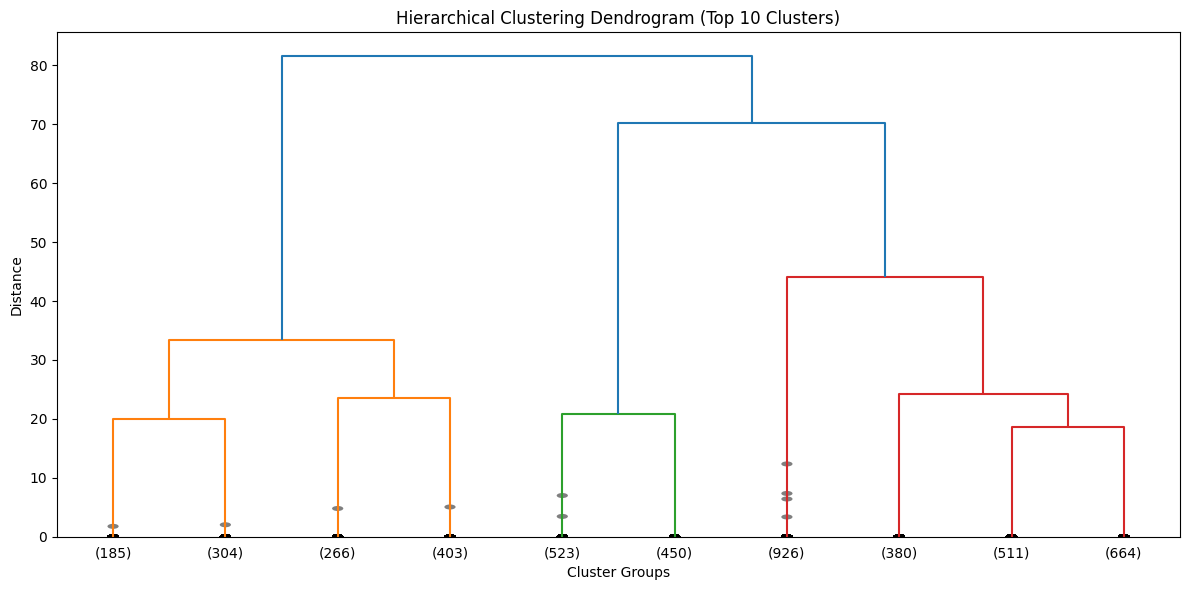

                    age_num  household_income_num
age_income_cluster                               
1.0                    47.0              238946.5
2.0                    27.1               76053.4
3.0                    61.6               99919.0
4.0                    44.9               95273.3
created customer_clusters.csv


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.preprocessing import StandardScaler

num_cols = ["age_num", "household_income_num"]
cat_cols = ["gender", "marital_status", "employment_status"]

# one-hot encode categoricals
ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
ct = ColumnTransformer([
    ("cat", ohe, cat_cols),
    ("pass_num", "passthrough", num_cols)
])
X = ct.fit_transform(df[cat_cols + num_cols])
ohe_names = ct.named_transformers_["cat"].get_feature_names_out(cat_cols)
feature_names = list(ohe_names) + num_cols
X_df = pd.DataFrame(X, columns=feature_names)

# 1. Drop rows with missing values
X_df = X_df.dropna()

# 2. Compute variance and pairwise correlations
variances = X_df.var().sort_values(ascending=False)
print("Feature Variances:\n",variances)


# --- Use both age and income ---
features = ["household_income_num", "age_num"]
X = df[features].dropna().astype(float)

# --- Scale features (important for Euclidean distance) ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# --- Hierarchical clustering ---
Z = linkage(X_scaled, method="ward")

plt.figure(figsize=(12, 6))
dendrogram(
    Z,
    truncate_mode="lastp",   # only show last merges (aggregated)
    p=10,                    # number of top clusters to show
    show_contracted=True,    # adds cluster sizes under leaves
    leaf_font_size=10,
)
plt.title("Hierarchical Clustering Dendrogram (Top 10 Clusters)")
plt.xlabel("Cluster Groups")
plt.ylabel("Distance")
plt.tight_layout()
plt.show()

# --- Extract clusters (adjust number as you like) ---
n_clusters = 4
clusters = fcluster(Z, n_clusters, criterion="maxclust")

# Add cluster labels back to your dataframe
df.loc[X.index, "age_income_cluster"] = clusters

# --- View summary of each cluster ---
print(df.groupby("age_income_cluster")[["age_num", "household_income_num"]].mean())

# --- Number of clusters (adjust to your chosen cutoff) ---
n_clusters = 4  # for example, you can change to 5 or whatever you used

# --- Generate cluster labels from your linkage matrix ---
clusters = fcluster(Z, n_clusters, criterion="maxclust")

# --- Create DataFrame of index + cluster ---
cluster_df = pd.DataFrame({
    "cluster": clusters
}, index=df.loc[X.index].index)  # preserve original customer indices

# --- Save to CSV file ---
cluster_df.to_csv("customer_clusters.csv", index=True)

print("created customer_clusters.csv")
